In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pymc3 as pm
from sampled import sampled
import seaborn as sns
import theano.tensor as tt

/Users/colin/.venv/bayes_talk/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def jointplot(ary):
    sns.jointplot(*ary.T, alpha=0.1, stat_func=None, xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

In [6]:
def metropolis_accept(old, new):
    return np.log(np.random.uniform()) < new - old


def normal_proposal(scale):
    def proposal(x):
        return np.random.normal(x, scale)
    return proposal


def metropolis(logp, n=1000, step_size=0.15, init=np.array([1, 0])):
    proposal = normal_proposal(step_size)
    accept = 0
    old = proposal(init)
    samples = []
    for _ in range(n):
        new = proposal(old)
        if metropolis_accept(logp(old), logp(new)):
            old = new
            accept += 1
        samples.append(old)
    print('Acceptance rate: {:.2f}%'.format(100 * accept / n))
    return np.array(samples)

In [7]:
def donut_pdf(scale):
    def logp(x):
        return -((1 - np.linalg.norm(x)) / scale) ** 2
    return logp

Acceptance rate: 24.90%


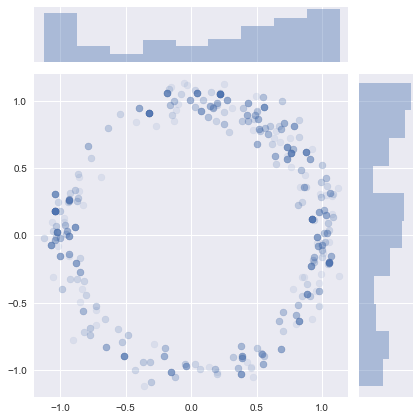

In [16]:
samples = metropolis(donut_pdf(0.1), n=1000, step_size=0.35)
jointplot(samples)

In [17]:
def tt_donut_pdf(scale):
    def logp(x):
         return -tt.square((1 - x.norm(2)) / scale)
    return logp

@sampled
def donut(scale=0.1, **observed):
    pm.DensityDist('donut', logp=tt_donut_pdf(scale), shape=2, testval=[0, 1])

100%|██████████| 1500/1500 [00:00<00:00, 7604.83it/s]


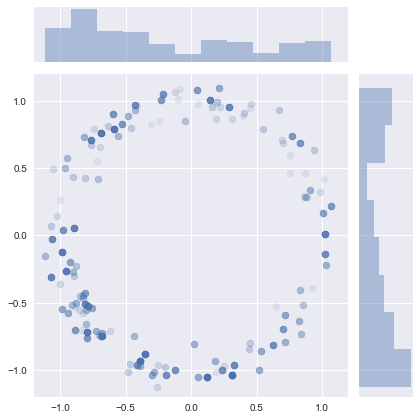

In [10]:
with donut(scale=0.1):
    metropolis_sample = pm.sample(draws=1000, step=pm.Metropolis())

jointplot(metropolis_sample.get_values('donut'))

100%|██████████| 1500/1500 [00:02<00:00, 561.90it/s]


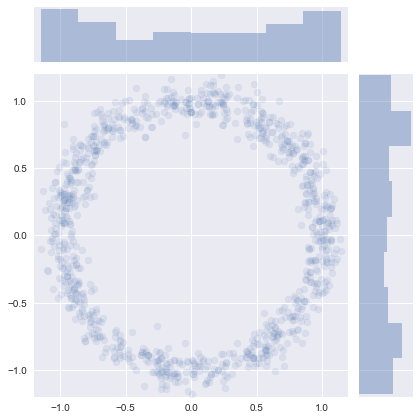

In [18]:
with donut(scale=0.1):
    nuts_sample = pm.sample(draws=1000, init=None, step=pm.NUTS())
    
jointplot(nuts_sample.get_values('donut'))